# EXTRACTION DE KEYWORDS POUR L'AMOUR ATYPIQUE
### Corpus CAMille - Presse belge francophone (1831-1993)


## Imports

In [74]:
import os
import re 
import yake
import pandas as pd
from tqdm import tqdm
import spacy
from collections import defaultdict


In [75]:
# Initialisation du modèle spaCy et YAKE
nlp = spacy.load("fr_core_news_lg", disable=["ner", "parser"])
kw_extractor = yake.KeywordExtractor(
    lan="fr",
    n=3,               #  Garde trigrammes (ex: "amour clandestin")
    dedupLim=0.85,     #  Assoupli (0.9 était trop strict)
    dedupFunc='seqm',  #  Méthode optimale
    windowsSize=1,     #  Réduit pour éviter le bruit
    top=200,           #  Augmenté pour couvrir plus de candidats
    stopwords=None,    #  Désactivé pour garder "amour", "mariage"
    features=None
)

In [76]:
# chein vers le ficher
data_path = "../../data/txt_tp4"
files = sorted([f for f in os.listdir(data_path) if f.endswith('.txt')])
print(f" {len(files)} fichiers trouvés (ex: {files[:3]})")

 512 fichiers trouvés (ex: ['KB_JB1051_1924-08-20_01-00004.txt', 'KB_JB1051_1928-05-11_01-00004.txt', 'KB_JB1051_1928-05-18_01-00004.txt'])


In [ ]:
def nettoyer_texte(text):
    """Nettoyage avancé pour texte historique (OCR + ponctuation)."""
    #  SUPPRIMER : re.sub(r'[^\w\s\'\-]', ' ', text)
    #  REMPLACER PAR :
    text = re.sub(r'[^\w\s\'\-àâäéèêëîïôöùûüç]', ' ', text)  # Garde accents
    text = re.sub(r'\b\w{1,2}\b', '', text)  # Supprime mots <3 lettres (ex: "xii")
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\b(hmu|xii|xix|xxe|xxx|[A-Z]{2,})\b', '', text, flags=re.IGNORECASE)  # Supprime artefacts OCR
    return text
def filtrer_keywords(keywords):
    """Filtre optimisé pour l'amour atypique dans la presse belge (1831-1993)."""
    #  LISTES CORRIGÉES (termes historiques + contextuels)
    mots_exclus = {
        "bruxelles", "rue", "place", "maison", "prix", "notaire", "trans", "transport",
        "ville", "année", "temps", "jour", "heure", "franc", "belge", "guerre",
        "loi", "roi", "église", "dieux", "dieux", "morts", "saint", "fête", "noël"
    }

    mots_cibles = {
        #  TERMES HISTORIQUES POUR L'AMOUR ATYPIQUE (19ème-20ème siècle)
        "amour", "mariage", "couple", "homosexuel", "lesbien", "lesbienne", "saphique",
        "inverti", "uraniste", "pédérastie", "sodomie", "concubinage", "union libre",
        "liaison", "passion", "désir", "affection", "sentiment", "secret", "clandestin",
        "scandale", "immoral", "déviant", "anormal", "péché", "vice", "honte", "caché",
        "illégal", "tolérance", "rejet", "stigmate", "église", "catholique", "condamnation",
        #  TERMES SPÉCIFIQUES À LA PRESSE BELGE
        "mœurs", "débauche", "corruption", "déshonneur", "honneur", "vertu", "chasteté",
        "concubine", "maîtresse", "adultère", "divorce", "séparation", "bastard", "illégitime"
    }

    keywords_filtres = []
    for kw, score in keywords:
        kw_lower = kw.lower()
        # SUPPRIMER : Toute la partie avec `nlp(kw)` (trop lente)
        #  LOGIQUE SIMPLIFIÉE :
        if any(exclu in kw_lower for exclu in mots_exclus):
            continue  # Exclut les mots non pertinents
        if any(cible in kw_lower for cible in mots_cibles):
            keywords_filtres.append((kw, float(score) * 0.7))  #  Score boosté pour les mots cibles
        elif len(kw.split()) >= 2:  # Garde les bigrammes/trigrammes neutres
            keywords_filtres.append((kw, float(score) * 1.0))

    # TRI PAR SCORE (du plus pertinent au moins pertinent)
    return sorted(keywords_filtres, key=lambda x: x[1])[:15]  # Top 15 max

In [79]:
# traitement 
results = []
for f in tqdm(files, desc="Traitement"):
    try:
        with open(os.path.join(data_path, f), 'r', encoding='utf-8', errors='ignore') as file:
            text = nettoyer_texte(file.read())
        keywords = kw_extractor.extract_keywords(text)
        keywords_filtres = filtrer_keywords(keywords)
        date_match = re.search(r'(\d{4}-\d{2}-\d{2})', f)
        date = date_match.group(1) if date_match else "1900-01-01"
        if keywords_filtres:
            results.append({
                "fichier": f,
                "date": date,
                "top_keywords": [
                    {"keyword": kw, "score": round(float(score), 6)}
                    for kw, score in keywords_filtres
                ]
            })
    except UnicodeDecodeError:
        print(f" Encodage invalide : {f} (essayez 'latin-1')")
    except Exception as e:
        print(f" Erreur avec {f}: {str(e)}")

Traitement: 100%|██████████| 512/512 [37:17<00:00,  4.37s/it]  


In [ ]:
# Afficher les résultats
if results:
    print(f"\n {len(results)} fichiers avec keywords pertinents")
    for i, res in enumerate(results[:10], 1):
        print(f"\n{i}. {res['fichier']} (Date: {res['date']})")
        print("   Top keywords:",
              [f"{kw['keyword']} (score: {kw['score']})"
               for kw in res['top_keywords'][:5]])


--- Top 10 fichiers avec keywords pertinents ---

1. KB_JB1051_1924-08-20_01-00004.txt (Date: 1924-08-20)
   Top bigrammes: Aucun
   Top keywords: ['ASSEMBLEE PLENIERE Dimanche (score: 0.0000)', 'che gli opérai (score: 0.0000)', 'Soignies Mme Demeuldre (score: 0.0000)', 'Mme Jean Matagne (score: 0.0000)', 'BORINAGE ASSEMBLEE PLENIERE (score: 0.0000)']

2. KB_JB1051_1928-05-11_01-00004.txt (Date: 1928-05-11)
   Top bigrammes: Aucun
   Top keywords: ["Gros plan d'un (score: 0.0000)", "d'un personnage d'un (score: 0.0000)", 'gros plan Exemple (score: 0.0000)', "films artistiques Jusqu'en (score: 0.0000)", "plan d'un grand (score: 0.0000)"]

3. KB_JB1051_1928-05-18_01-00004.txt (Date: 1928-05-18)
   Top bigrammes: Aucun
   Top keywords: ['RAYON Slt Vendredi (score: 0.0000)', "ïeil c'est l'appareil (score: 0.0000)", 'local habituel RAYON (score: 0.0000)', 'Meetings GESVES Dimanche (score: 0.0000)', 'Mendiants LOUIS PAUL (score: 0.0000)']

4. KB_JB1051_1928-05-22_01-00004.txt (Date: 1928-05

In [85]:
df = pd.DataFrame([
        {
            "fichier": r["fichier"],
            "date": r["date"],
            "keywords": "; ".join([
                f"{kw['keyword']} ({kw['score']})"
                for kw in r["top_keywords"]
            ])
        }
        for r in results
    ])
df.to_csv(
        "../../data/results/keywords_amour_atypique_final.csv",
        index=False,
        encoding='utf-8-sig',
        sep=';'
    )
print(f"\n Export CSV terminé ({len(df)} entrées)")


 Export CSV terminé (512 entrées)


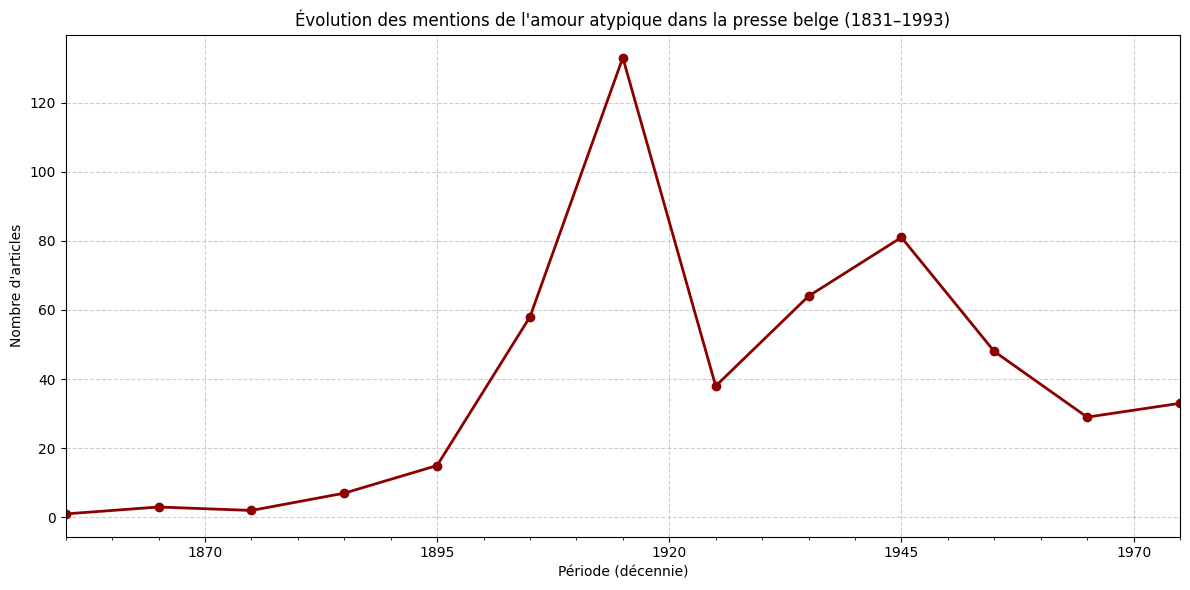

In [84]:
if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df = df.dropna(subset=['date'])
        if len(df) > 10:
            plt.figure(figsize=(12, 6))
            df.set_index('date').resample('10YE').size().plot(
                kind='line', marker='o', color='darkred', linewidth=2,
                title="Évolution des mentions de l'amour atypique dans la presse belge (1831–1993)",
                xlabel="Période (décennie)", ylabel="Nombre d'articles"
            )
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.savefig("../../data/results/evolution_amour_atypique.png", dpi=300, bbox_inches='tight')
            plt.show()
        else:
            print("⚠️ Pas assez de données pour générer un graphique fiable.")
else:
    print("\n AUCUN RÉSULTAT TROUVÉ. Voir suggestions ci-dessus.")